In [13]:
# for the script below to work , you may need to install these packages
#using Pkg
#Pkg.add("CSV")
#Pkg.add("Dates")
#Pkg.add("DataFrames")
#Pkg.add("CPUTime")
#Pkg.add("PyCall")
#Pkg.add("LaTeXStrings")
#Pkg.add("Query")
#Pkg.add("PyPlot")
#Pkg.add("Plots")
#Pkg.add("PyCall")
#Pkg.add("Statistics")
println("done loading packages")

done loading packages


In [1]:
using Dates, DataFrames, CSV, CPUTime, PyCall, LaTeXStrings, Query

#@time trips = CSV.read("$(Base.source_dir())/../data/sample_100000.csv", separator = ',')
@time trips = CSV.read("$(Base.source_dir())/../data/sample_1000.csv", separator = ',')
@time zips = CSV.read("$(Base.source_dir())/../data/zip_codes_states.csv", separator = ',')

println("finished read")

#prepare_data
@time prepare_data = @from i in trips begin    
            @select {i..., tip_percentage=100*(i.tip_amount / (i.total_amount - i.tip_amount))}
            @collect DataFrame
       end

NYC_region=[-74.15,40.5,-73.65,41]

#clean_data
@time clean_data = @from i in prepare_data begin   
            @where i.tip_amount>0 &&
    i.pickup_longitude > NYC_region[1]  && 
                    i.pickup_longitude < NYC_region[3]  &&
                    i.dropoff_latitude > NYC_region[2] &&
                    i.dropoff_latitude < NYC_region[4] &&
                    i.payment_type == 1 && #creditcard
                    i.passenger_count > 0
            @select {i...,new_tip_amount=i.tip_amount}
            @collect DataFrame
       end

NYCzips = zips[zips[:state] .== "NY", :]

function getZipCode(zips, lat, lon, step)   
    step = parse(Float64,step)
    
    area_borders = [lat-step, lat+step, lon-step, lon+step]
    
    zips =zips[completecases(zips), :]
    local_zips = filter(r -> (r.latitude > area_borders[1]) &
        (r.latitude < area_borders[2]) &
        (r.longitude > area_borders[3]) &
        (r.longitude < area_borders[4]), zips)
    
    if(nrow(local_zips)==0)        
        if (step<2)
                # if there are no ZIP codes in the borders, enlarge the borders and recursively repeat the operation
                r = getZipCode(zips, lat, lon, step+0.2)
        else
                # if step is already too big - just return NA
                r = str("000000")
        end       
     else
        # calculate the distances to the ZIP codes filtered
        #local_zips.distance = local_zips.latitude + local_zips.longitude
        local_zips.distance_proxy = local_zips.latitude
        
        for i in 1:size(local_zips, 1) 
            local_zips[i, :distance_proxy] = sqrt((local_zips[i, :latitude] - lat)^2 +
                (local_zips[i, :longitude] - lon)^2)
        end
        #println(local_zips)
        # local_zips.distance = sqrt((local_zips.latitude-lat)^2 + (local_zips.longitude-lon)^2)
        # sort the filtered ZIP codes according to the distance
        sort!(local_zips, :distance_proxy, rev=true)
        #zips = local_zips[order(local_zips.distance),]
        # return the nearest ZIP code
        r = local_zips[1,:zip_code]
    end
            
    return   string(r)
    
end
        

#augument_data
clean_data.zip_code = clean_data.tpep_pickup_datetime
@time @CPUtime for i in 1:size(clean_data, 1) 
    clean_data[i, :zip_code] = string( getZipCode(NYCzips,
                clean_data[i, :pickup_latitude],
                clean_data[i, :pickup_longitude],"0.2"))
end

    
head(clean_data)

# this takes up to a minute to run and so be patient


  1.261101 seconds (2.91 M allocations: 137.759 MiB, 5.34% gc time)
  0.258849 seconds (793.57 k allocations: 20.054 MiB, 5.51% gc time)
finished read
  0.974976 seconds (2.29 M allocations: 113.564 MiB, 5.35% gc time)
  1.042688 seconds (2.23 M allocations: 108.883 MiB, 5.63% gc time)
elapsed CPU time: 1.49 seconds
  1.578377 seconds (26.31 M allocations: 615.012 MiB, 9.46% gc time)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,new_tip_amount,zip_code
,Int64⍰,String⍰,String⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,String⍰,Float64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,String⍰
1,1,10804,2015-01-08 22:51:35,1,1.6,-73.9722,40.7593,1,N,-73.9861,40.7401,1,7.5,0.5,0.5,1.2,0.0,10.0,13.6364,1.2,10804
2,2,10583,2015-01-08 22:46:37,1,0.52,-73.9727,40.7933,1,N,-73.9713,40.7971,1,4.0,0.5,0.5,0.9,0.0,6.2,16.9811,0.9,10583
3,2,10475,2015-01-08 22:55:05,3,6.23,-74.0115,40.7027,1,N,-73.9595,40.7629,1,18.5,0.5,0.5,3.8,0.0,23.6,19.1919,3.8,10475
4,2,10306,2015-01-08 22:59:12,1,5.88,-73.9287,40.7439,5,N,-73.8552,40.7278,1,75.0,0.0,0.0,5.0,0.0,80.3,6.64011,5.0,10306
5,2,10804,2015-01-08 23:02:04,1,3.48,-73.9744,40.7553,1,N,-73.981,40.7212,1,15.0,0.5,0.5,3.1,0.0,19.4,19.0184,3.1,10804
6,1,10804,2015-01-08 22:48:17,1,1.0,-73.977,40.7523,1,N,-73.9776,40.7629,1,5.0,0.5,0.5,3.0,0.0,9.3,47.619,3.0,10804


In [2]:
using Statistics
@time by(clean_data, :payment_type, df -> mean(df.tip_amount))

head(clean_data)

# this should finish in 5 seconds

  4.171103 seconds (13.00 M allocations: 715.163 MiB, 12.29% gc time)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,new_tip_amount,zip_code
,Int64⍰,String⍰,String⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,String⍰,Float64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,String⍰
1,1,10804,2015-01-08 22:51:35,1,1.6,-73.9722,40.7593,1,N,-73.9861,40.7401,1,7.5,0.5,0.5,1.2,0.0,10.0,13.6364,1.2,10804
2,2,10583,2015-01-08 22:46:37,1,0.52,-73.9727,40.7933,1,N,-73.9713,40.7971,1,4.0,0.5,0.5,0.9,0.0,6.2,16.9811,0.9,10583
3,2,10475,2015-01-08 22:55:05,3,6.23,-74.0115,40.7027,1,N,-73.9595,40.7629,1,18.5,0.5,0.5,3.8,0.0,23.6,19.1919,3.8,10475
4,2,10306,2015-01-08 22:59:12,1,5.88,-73.9287,40.7439,5,N,-73.8552,40.7278,1,75.0,0.0,0.0,5.0,0.0,80.3,6.64011,5.0,10306
5,2,10804,2015-01-08 23:02:04,1,3.48,-73.9744,40.7553,1,N,-73.981,40.7212,1,15.0,0.5,0.5,3.1,0.0,19.4,19.0184,3.1,10804
6,1,10804,2015-01-08 22:48:17,1,1.0,-73.977,40.7523,1,N,-73.9776,40.7629,1,5.0,0.5,0.5,3.0,0.0,9.3,47.619,3.0,10804


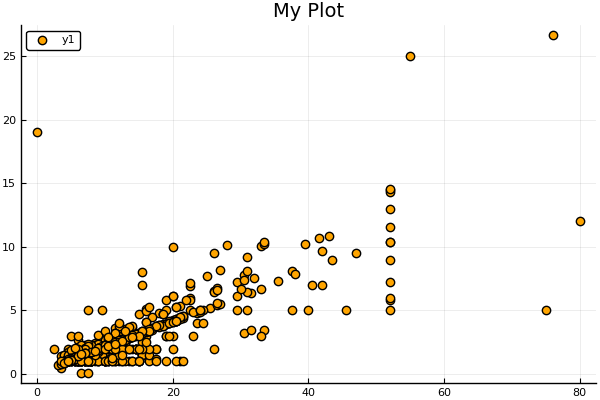

In [3]:
# this does not build easily but if you fiddle with it, it will eventually work
# https://docs.juliaplots.org/latest/examples/pyplot/

# use Plots engine
using Plots, PyCall
pyplot()
#plot(Plots.fakedata(50,5),w=3)
scatter!(clean_data.fare_amount, clean_data.tip_amount, markersize=6, c=:orange, title="My Plot")
#plotly() # Choose the Plotly.jl backend for web interactivity
#plot(rand(5,5),linewidth=2,title="My Plot")

# use PyPlot engine
#using PyPlot, PyCall
#pyplot() # Switch to using the PyPlot.jl backend
#plot(rand(5,5),linewidth=2,title="My Plot") # The same plotting command works